$\newcommand{\similarity}{\text{similarity}}$

# Link prediction

- https://en.wikipedia.org/wiki/Link_prediction
- [Link Prediction in Complex Networks: A Survey](https://arxiv.org/pdf/1010.0725.pdf)

**Tasks**
1. Predicting missing links -- Given a graph compute missing links from a graph
2. Predicting future links -- Given a snapshot of a graph at time $t$ compute the snapshot at a later time $t'$ 

# Similarity based algorithms

The simplest idea is a similarity based framework where each pair of nodes $(u, v)$ is assigned a score which is defined as similarity. All links are ranked according to the scores and links between similar nodes have a higher probability to appear:
$$P(A[u, v] = 1) \propto \similarity(u, v)$$

**How to define similarity?**  
The definitions of similarities are broad but the intuition is that 2 nodes are close if they have many common features. This features can be computed from
- Node features
- Structural properties

## Topological based methods:

### Local methods
**Assumption**: nodes with similar network structure are more likely to form a link. 

**Common neighbours**  
2 nodes are more likely to have a link if they have amany common neighbours
$$\text{CN}_{uv}  = |N(u) \cap N(v)|$$

**Jaccard measure**  
Ratio of common neighbors to all neighbors
$$\text{J}_{uv}  = \dfrac {|N(u) \cap N(v)|} {|N(u) \cup N(v)|}$$

**Adamic-Adar measure**  
If we share neighbors with low degree we are likely to connect. Connecting through hub is meaningless.  
The log is there to reduce the high degrees from the hubs (exponential due to power law degree distribution) --  in practice this yields good results

$$\text{A}_{uv}  = \sum_{w \in N(u) \cap N(v)} \dfrac {1} {\log(|N(w)|}$$

### Global methods
**Katz index similarity**  
Count the number of paths of all lenghts between a pair of nodes
$$K_{uv} = \sum_{i=1}^\infty\beta^iA^i[u, v]$$
where $\beta \in \mathbb R^+$ is a user-defined parameter controlling how much weight is given to short vs long paths. Reminder: $A^i_{uv}$ counts the number of paths of length $i$ between $u, v$.

**There are other approaches that won't be detailed here**

- [SimRank](https://en.wikipedia.org/wiki/SimRank)
- Random walks (*Intuition*: how likely we are to reach each node from a random walk starting from the other node if we walk randomly)
- PageRank
**Problems**
- The problem with this approaches is that they work usually in social-like networks. (They prioritise neighboourhood connections). In reality not all nodes are like these.
- Hard to scale up, computationally expensive
- Not leveraging node data

Luckily for us, networkx already has most of these similarity measurements
- https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html

In [1]:
import networkx as nx
import numpy as np
import itertools
import os, sys
import matplotlib.pyplot as plt

from typing import List

In [2]:
G = nx.karate_club_graph()

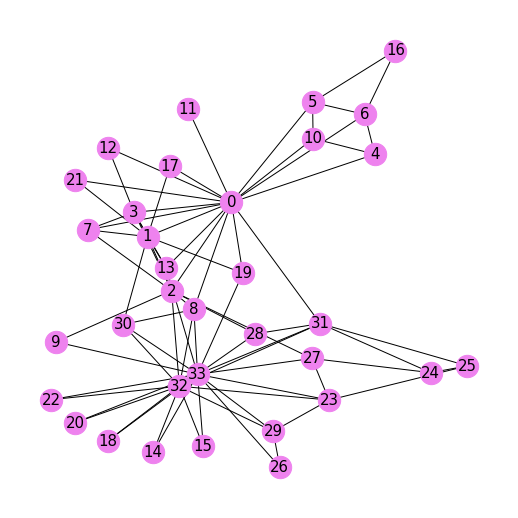

In [3]:
plt.figure(figsize = (7, 7))
pos = nx.spring_layout(G, seed = 42)
nx.draw(G, pos = pos, with_labels=True, node_size = 500, node_color = 'violet', font_size = 15, )

In [4]:
{1, 2, 3} & {2, 3, 4}

{2, 3}

In [5]:
def common_neighbours_sim(G, edges: List[tuple]):
    res = []
    for (u, v) in edges:
        N_u = set(G.neighbors(u))
        N_v = set(G.neighbors(v))
        cn = len(N_u.intersection(N_v))
        res.append((u, v, cn))
    return res

def jaccard_coefficient(G, edges: List[tuple]):
    res = []
    for (u, v) in edges:
        N_u = set(G.neighbors(u))
        N_v = set(G.neighbors(v))
        jc = len(N_u.intersection(N_v)) / len(N_u.union(N_v))
        res.append((u, v, jc))
    return res

def adam_adar(G, edges: List[tuple]):
    res = []
    for (u, v) in edges:
        
        N_u = set(G.neighbors(u))
        N_v = set(G.neighbors(v))
        aa = sum(1 / np.log(len(list(G.neighbors(w)))) for w in N_u.intersection(N_v))
        res.append((u, v, aa))
    return res

In [79]:
common_neighbors_sim(G, [(25, 16), (16, 10), (25, 0)])

[(25, 16, 0), (16, 10, 1), (25, 0, 1)]

In [70]:
jaccard_coefficient(G, [(25, 16), (16, 10), (25, 0)])

[(25, 16, 0.0), (16, 10, 0.25), (25, 0, 0.05555555555555555)]

In [89]:
adam_adar(G,  [(25, 16), (16, 10), (25, 0)])

[(25, 16, 0), (16, 10, 0.7213475204444817), (25, 0, 0.5581106265512472)]

In [90]:
# Let's look at some non-edges
targets = list(nx.non_edges(G))
sorted(jaccard_coefficient(G, targets), key = lambda x: x[2], reverse=True)[:10]

[(14, 15, 1.0),
 (14, 18, 1.0),
 (14, 20, 1.0),
 (14, 22, 1.0),
 (15, 18, 1.0),
 (15, 20, 1.0),
 (15, 22, 1.0),
 (17, 21, 1.0),
 (18, 20, 1.0),
 (18, 22, 1.0)]

In [91]:
targets = list(nx.non_edges(G))
sorted(adam_adar(G, targets), key = lambda x: x[2], reverse=True)[:10]

[(2, 33, 4.719381261461351),
 (0, 33, 2.7110197222973085),
 (1, 33, 2.252921681630931),
 (4, 5, 1.9922605072935597),
 (6, 10, 1.9922605072935597),
 (7, 13, 1.8081984819901584),
 (2, 31, 1.6733425912309228),
 (23, 31, 1.6656249548734432),
 (23, 24, 1.631586747071319),
 (0, 32, 1.613740043014111)]

# Embeddings

What we've looked at are methods to predict links based on structural components. Yet we often have node features that we want to incorporate in this task. To do that we can compute embeddings $h_u, h_v$  for nodes $u, v$ and predict using them.


We have multiple options:
1. Aggregate embeddings (concatenate, sum etc) + linear predictor (like in GAT)
2. Dot product between embeddings
    - $\hat{y}_{uv} = h_u^Th_v$ -- here $\hat{y}_{uv}$ is a single number => we can do a binary prediction
    - $\hat{y}^{(1)}_{uv} = h_u^TW^{(1)}h_v \ \dots \ \hat{y}^{(k)}_{uv} = h_u^TW^{(k)}h_v$ -- We can use a weight matrix $W$  / class for a k-class prediction. After that we concatenate the final results

**Negative sampling**  
One problem with real graphs is that they are sparse. Let our graph G have $n$ nodes and $m$ edges. The number of possible edges is the one of a complete graph: $\dfrac {n(n-1)} 2$. In practice $m$ is much smaller than that. In order to generate more edges we can sample **negative edges** (edges that are not in the graph) and label them accordingly.

**Remark**: The resampling is usually done each training split



In [192]:
import copy
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset

from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as py_T
from torch_geometric.utils import negative_sampling
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [159]:
# Split with Deepsnap

# pyg_dataset = Planetoid(root = os.path.join('..', 'data', 'tmp', 'Cora'), name = 'Cora')
# graph = Graph.pyg_to_graph(pyg_dataset[0])

# dataset = GraphDataset([graph], task = "link_pred", edge_train_mode='all')
# dataset.to(device)
# data = dataset[0]
# dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, 
#                                                          split_ratio=[0.6, 0.2, 0.2], 
#                                                          )
# # Every dataset has 1 graph
# data_train, data_val, data_test = dataset_train[0], dataset_val[0], dataset_test[0]
# data_train.to(device)
# data_val.to(device)
# data_test.to(device)

# print(data_train)
# print(data_val)
# print(data_test)


In [142]:
# Split with torch_geometric

dataset = Planetoid(root = os.path.join('..', 'data', 'tmp', 'Cora'), name = 'Cora')
data = dataset[0]
split = py_T.RandomLinkSplit(num_val = .2, num_test = .2, split_labels=False, is_undirected=False)
data_train, data_val, data_test = split(data)

data_train.to(device)
data_val.to(device)
data_test.to(device)

print(data_train)
print(data_val)
print(data_test)

Data(x=[2708, 1433], edge_index=[2, 6334], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[12668], edge_label_index=[2, 12668])
Data(x=[2708, 1433], edge_index=[2, 6334], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[4222], edge_label_index=[2, 4222])
Data(x=[2708, 1433], edge_index=[2, 8445], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[4222], edge_label_index=[2, 4222])


## Predicting on node2vec embeddings

[node2vec example](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/node2vec.py) -- Most of the code is from here

Here we will use node2vec to produce node embeddings. We will then aggregate them to compute an edge embedding and use some basic predictor to predict on them

In [165]:
from torch_geometric.nn.models import Node2Vec

In [236]:
model = Node2Vec(data.edge_index, embedding_dim=64, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=.005)

In [237]:
def train(model,loader, optimizer):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test(model, data):
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

for epoch in range(1, 101):
    loss = train(model, loader, optimizer)
    acc = test(model, data)
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

Epoch: 20, Loss: 1.2275, Acc: 0.4560
Epoch: 40, Loss: 0.9062, Acc: 0.6480
Epoch: 60, Loss: 0.8548, Acc: 0.6900
Epoch: 80, Loss: 0.8392, Acc: 0.6950
Epoch: 100, Loss: 0.8343, Acc: 0.7070


In [238]:
z = model()

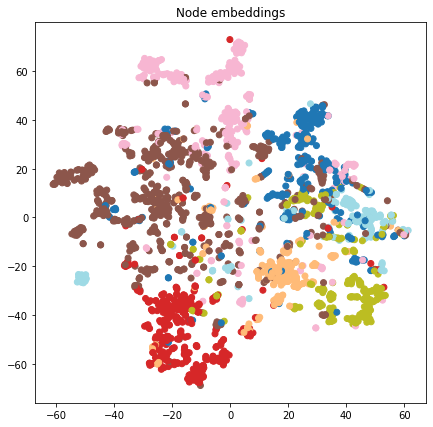

In [239]:
# Plot embeddings

#emb = PCA(n_components=2).fit_transform(z.detach().cpu().numpy())
emb = TSNE(n_components=2).fit_transform(z.detach().cpu().numpy())

plt.figure(figsize = (7, 7))
plt.title("Node embeddings")
plt.scatter(*emb.T, c = data.y, cmap = plt.cm.tab20)
plt.show()



In [240]:
z[0].shape

torch.Size([64])

In [241]:
data.edge_index.shape

torch.Size([2, 10556])

In [242]:
edge_emb = torch.cat([z[data.edge_index[0]], z[data.edge_index[1]]], dim = 1)
edge_emb.shape

torch.Size([10556, 128])

In [243]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [244]:
data_train

Data(x=[2708, 1433], edge_index=[2, 6334], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[12668], edge_label_index=[2, 12668])

In [245]:
# Compute edge by concatenating and transfer to numpy

edge_emb_train = torch.cat([z[data_train.edge_label_index[0]], z[data_train.edge_label_index[1]]], dim = 1).detach().cpu().numpy()
edge_emb_val = torch.cat([z[data_val.edge_label_index[0]], z[data_val.edge_label_index[1]]], dim = 1).detach().cpu().numpy()
edge_emb_test = torch.cat([z[data_test.edge_label_index[0]], z[data_test.edge_label_index[1]]], dim = 1).detach().cpu().numpy()

y_train = data_train.edge_label.detach().cpu().numpy()
y_val = data_val.edge_label.detach().cpu().numpy()
y_test = data_test.edge_label.detach().cpu().numpy()

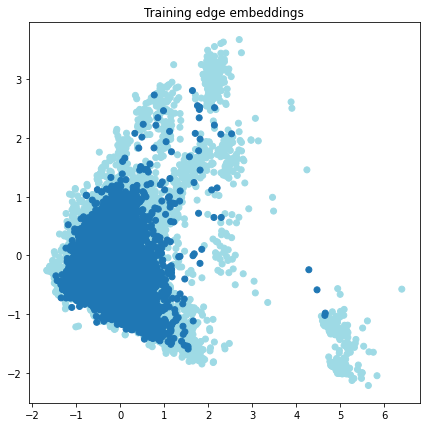

In [277]:
# Plot edge embeddings

from sklearn.decomposition import PCA
# fit and transform using PCA
emb = PCA(n_components=2).fit_transform(edge_emb_train)
#emb = TSNE(n_components=2).fit_transform(edge_emb_train)

plt.figure(figsize = (7, 7))
plt.title("Training edge embeddings")
plt.scatter(*emb.T, c = data_train.edge_label.detach().cpu().numpy(), cmap = plt.cm.tab20)
plt.show()

In [255]:
clf = RandomForestClassifier(max_depth=14, random_state=42)
clf.fit(edge_emb_train, y_train)

accuracy_score(y_train, clf.predict(edge_emb_train))

0.9809756867698137

In [256]:
accuracy_score(y_val, clf.predict(edge_emb_val))

0.9296541923259118

In [257]:
accuracy_score(y_test, clf.predict(edge_emb_test))

0.9291804831833255

## Using GNNs

Here we are going to use SageConv to compute node embeddings then compute the dot product between the node embeddings to compute the edge prediction

In [258]:
def resample_negative(data):
    neg_edges = negative_sampling(data.edge_index)
    print(neg_edges)
    pos_edges = data.edge_label_index.T[data.edge_label==1].T
    
    data.edge_label_index = torch.cat([pos_edges, neg_edges], dim = 1)
    data.edge_label = torch.cat([torch.ones(pos_edges.shape[1]), torch.zeros(neg_edges.shape[1])])
    return data

In [259]:
class LinkPredModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout = .2, negative_slope = .2, dot_product = True):
        super(LinkPredModel, self).__init__()
        
        # Convolution layers
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        if not dot_product:
            self.classifier = torch.nn.Linear(2 * hidden_dim, 1) # hardcoded output dim
    
        self.loss_fn = F.binary_cross_entropy_with_logits
        
        self.negative_slope = negative_slope
        self.dropout=dropout
        self.dot_product = dot_product

    def forward(self, x, edge_index, edge_label_index):
        
        # Compute embeddings
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x, negative_slope=self.negative_slope)
        if self.training:
            x = F.dropout(x, p = self.dropout)
        x = self.conv2(x, edge_index)
        
        x_src = x[edge_label_index[0]] # Take the embeddings of the source nodes
        x_trg = x[edge_label_index[1]] # Take the embeddings of the targe nodes
        
        # dot product h^t * h
        if self.dot_product:
            out = torch.sum(x_src * x_trg, dim = 1) # Dot product 
        else:
            # Concat and MLP version
            x = torch.cat([x_src, x_trg], dim = 1)
            #x = torch.sum([x_src, x_trg], dim = 1)
            out = self.classifier(x).squeeze()
            
        
        return out
    
    def loss(self, preds, link_label):
        return self.loss_fn(preds, link_label.type(preds.dtype))
            

        

In [260]:
torch.sum(data_train.x[data_train.edge_label_index[0]] * \
          data_train.x[data_train.edge_label_index[1]], dim = 1).shape

torch.Size([12668])

In [261]:
torch.cat([data_train.x[data_train.edge_label_index[0]], 
           data_train.x[data_train.edge_label_index[1]]], dim = 1).shape

torch.Size([12668, 2866])

In [262]:
data.num_node_features

1433

In [263]:
data_val.x.is_cuda

True

In [264]:
# Initialize model and parameters

model = LinkPredModel(data.num_node_features, 256, dot_product = True)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = .001)
#loss_function = F.binary_cross_entropy_with_logits


In [265]:
def train(model, data_train, data_val, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data_train.x, data_train.edge_index, data_train.edge_label_index)
    loss = model.loss(out, data_train.edge_label)
    loss.backward()
    optimizer.step()
    
    loss_train, acc_train = test(model, data_train)
    loss_val, acc_val = test(model, data_val)
    return loss_train, acc_train, loss_val, acc_val
    
@torch.no_grad()
def test(model, data):    
    out = model(data.x, data.edge_index, data.edge_label_index)
    loss = model.loss(out, data.edge_label.type(out.dtype))
    acc = accuracy_score(data.edge_label.detach().cpu(), torch.sigmoid(out).round().detach().cpu().numpy())
    #acc = accuracy_score(data.edge_label.detach().cpu(), torch.argmax(out, axis = 1).detach().cpu().numpy())
    
    return loss.item(), acc
    

epochs = 51
best_model, best_loss = None, None
for epoch in range(epochs):
    loss_train, acc_train, loss_val, acc_val = train(model, data_train, data_val, optimizer)
    # Save best model
    if best_loss is None or loss_val < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = loss_val
        best_epoch = epoch
    if epoch % 10 == 0:
        print(f"{epoch=} \t {loss_train=:.2f} | {acc_train=:.2f} \t {loss_val=:.2f} | {acc_val=:.2f}")

epoch=0 	 loss_train=0.68 | acc_train=0.50 	 loss_val=0.69 | acc_val=0.50
epoch=10 	 loss_train=0.45 | acc_train=0.79 	 loss_val=0.52 | acc_val=0.75
epoch=20 	 loss_train=0.32 | acc_train=0.87 	 loss_val=0.49 | acc_val=0.77
epoch=30 	 loss_train=0.19 | acc_train=0.93 	 loss_val=0.55 | acc_val=0.76
epoch=40 	 loss_train=0.09 | acc_train=0.98 	 loss_val=0.78 | acc_val=0.74
epoch=50 	 loss_train=0.03 | acc_train=0.99 	 loss_val=1.08 | acc_val=0.74


In [266]:
print(best_epoch)
print(test(best_model, data_test))

20
(0.4786509573459625, 0.7643297015632402)
